# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### Open Street Map

In [1]:
from straeto.data import get_osm_data

get_osm_data(verbose=True)

gis_osm_roads_free_1.cpg extracted to osm-data/
gis_osm_roads_free_1.dbf extracted to osm-data/
gis_osm_roads_free_1.prj extracted to osm-data/
gis_osm_roads_free_1.shp extracted to osm-data/
gis_osm_roads_free_1.shx extracted to osm-data/
Running extract_roads bash script...
Success


In [2]:
!printf 'osm-data:\n' && ls osm-data/ && printf '\nosm-data/output:\n' && ls osm-data/output

osm-data:
gis_osm_roads_free_1.cpg  gis_osm_roads_free_1.prj  gis_osm_roads_free_1.shx
gis_osm_roads_free_1.dbf  gis_osm_roads_free_1.shp  output

osm-data/output:
extracted_roads.cpg  extracted_roads.shx     no_extracted_roads.shp
extracted_roads.dbf  no_extracted_roads.cpg  no_extracted_roads.shx
extracted_roads.prj  no_extracted_roads.dbf
extracted_roads.shp  no_extracted_roads.prj


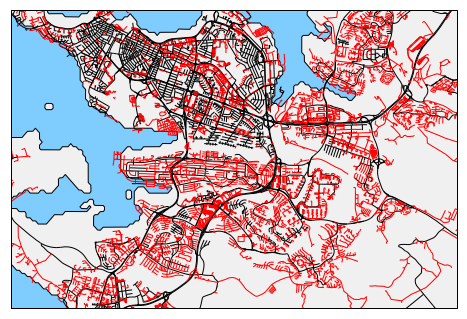

In [3]:
from straeto import straeto
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = straeto.get_map(region='reykjavik', res='f', zoom=1.5)

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp', edgecolor='red')

plt.show()

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [4]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 34,
 'route': '1-A',
 'gpsTime': '180528220106',
 'lat': 64.1118033333333,
 'lon': -21.9085666666667,
 'speed': 4.94,
 'heading': 196.08,
 'gpsFix': 2,
 'routeNumber': '1',
 'lastStop': 10000802,
 'nextStop': 10000854,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

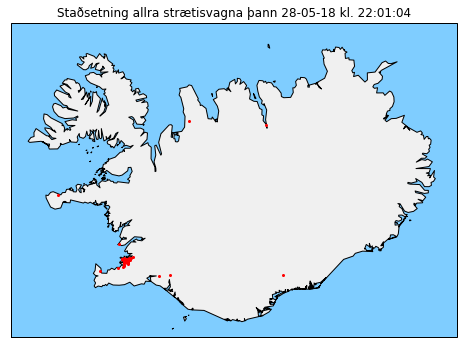

In [5]:
from datetime import datetime

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [6]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

27 27


In [7]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
43-B | k = 55.18 / 29.05 = 1.9 | 27.69 --> 30.4
7-B | k = 47.65 / 27.16 = 1.75 | 36.5 --> 17.83
57-A | k = 23.19 / 12.82 = 1.81 | 14.43 --> 11.21
15-B | k = 69.05 / 37.0 = 1.87 | 35.25 --> 38.76
1-B | k = 26.99 / 15.82 = 1.71 | 14.92 --> 16.73
57-C | k = 95.44 / 50.53 = 1.89 | 50.02 --> 51.03
4-A | k = 49.94 / 27.02 = 1.85 | 33.27 --> 20.76
15-A | k = 22.94 / 12.47 = 1.84 | 5.38 --> 19.56
12-C | k = 49.18 / 26.08 = 1.89 | 24.56 --> 27.6
24-A | k = 56.94 / 30.18 = 1.89 | 27.85 --> 32.5
51-C | k = 97.09 / 52.59 = 1.85 | 53.28 --> 51.91
43-A | k = 19.43 / 10.55 = 1.84 | 10.6 --> 10.5
55-A | k = 97.4 / 52.98 = 1.84 | 52.77 --> 53.18
51-D | k = 93.72 / 50.56 = 1.85 | 50.47 --> 50.65
11-C | k = 26.5 / 14.07 = 1.88 | 15.22 --> 12.92
18-B | k = 66.14 / 36.82 = 1.8 | 37.57 --> 36.07
4-D | k = 23.44 / 12.99 = 1.8 | 17.45 --> 8.53
Bad:
28-A | k = 34.88 / 16.14 = 2.16 | 19.78 --> 12.5
11-A | k = 39.83 / 20.84 = 1.91 | 22.15 --> 19.53
11-B | k = 17.15 / 11.44 = 1.5 | 12.79 --> 10.09
2-C | k =

## Undirbúningur gagna:
Load sqlite files:
```
pgloader 25-03-2018.db postgresql:///straeto
```
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```
Aðeins hraðara: (37-39 sec með index)
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);
```

In [39]:
%alias sql psql straeto -c

In [40]:
sql "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | buses           | table | arni
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(3 rows)



In [28]:
sql "ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);"

ERROR:  column "geom" of relation "buses" already exists


In [31]:
sql "UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);"

UPDATE 1001


In [33]:
sql "CREATE INDEX buses_gix ON buses USING gist(geom);"

ERROR:  relation "buses_gix" already exists


In [35]:
sql "VACUUM ANALYZE;"

VACUUM


In [34]:
sql "ALTER TABLE buses ADD maxspeed integer;"

ERROR:  column "maxspeed" of relation "buses" already exists
